In [1]:
%pip install xgboost==1.7.5

  Using cached xgboost-1.7.5-py3-none-macosx_12_0_arm64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.5-py3-none-macosx_12_0_arm64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pyarrow
import fastparquet
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter('ignore')

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import itertools

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

In [2]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarized. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [3]:
# Alias
train = df_train_non_agg
test_final = df_final_test_non_agg
train_agg = df_train_agg
test_final_agg = df_final_test_agg

# On aggregated data

In [7]:
y_agg = train_agg.pop('target')

# Train-Test-Split
# 20% examples in test data
X_train, X_temp, y_train, y_temp = train_test_split(train_agg,
                                         y_agg, 
                                         stratify = y_agg,
                                         test_size = 0.3, 
                                         random_state = 42)
# Train-eval split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# Features for feature importance
features = list(X_train.columns)

In [9]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10)

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 1.0],
    'scale_pos_weight': [1, 5, 10, 20]  # useful for class imbalance!
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1,
    random_state=42
)

search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8;, score=0.001 total time=  16.1s
[CV 2/3] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=0.8;, score=0.001 total time=  16.7s
[CV 2/3] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=10, subsample=0.8;, score=0.239 total time=  22.0s
[CV 3/3] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=10, subsample=0.8;, score=0.227 total time=  22.3s
[CV 1/3] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=10, subsample=0.8;, score=0.227 total time=  22.4s
[CV 3/3] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, su

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 1.0],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200],
                                        'scale_pos_weight': [1, 5, 10, 20],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=5)

In [10]:
print("Best parameters:", search.best_params_)

Best parameters: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}


In [12]:
best_XGB_after_RandomizedSearch = search.best_estimator_

In [13]:
best_XGB_after_RandomizedSearch.save_model('best_xgb_after_randomized_search.model')

In [19]:
# Using Grid search on best params from Randomized search
# Best parameters: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}
xgb2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10, scale_pos_weight=10, colsample_bytree=1.0, subsample=0.8, n_estimators=100)

grid = {
    'learning_rate': [0.05, 0.1],         # Slightly wider around 0.1
    'max_depth': [4, 5],                     # Try just below and above
    'gamma': [0.3, 0.5],                   # Explore near current
}

gsearch = GridSearchCV(
    xgb2,
    param_grid=grid,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1
)

gsearch.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END gamma=0.3, learning_rate=0.1, max_depth=4;, score=0.246 total time=  21.6s
[CV 1/3] END gamma=0.3, learning_rate=0.05, max_depth=4;, score=0.236 total time=  21.7s
[CV 2/3] END gamma=0.3, learning_rate=0.05, max_depth=4;, score=0.246 total time=  21.8s
[CV 2/3] END gamma=0.3, learning_rate=0.1, max_depth=4;, score=0.249 total time=  21.8s
[CV 3/3] END gamma=0.3, learning_rate=0.05, max_depth=4;, score=0.242 total time=  22.3s
[CV 2/3] END gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.251 total time=  27.2s
[CV 1/3] END gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.241 total time=  27.3s
[CV 3/3] END gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.244 total time=  27.6s
[CV 3/3] END gamma=0.3, learning_rate=0.1, max_depth=4;, score=0.243 total time=  23.0s
[CV 1/3] END gamma=0.5, learning_rate=0.05, max_depth=4;, score=0.236 total time=  22.8s
[CV 2/3] END gamma=0.3, learning_rate=0.1, max_depth=

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=1.0,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.3, 0.5], 'learning_rate': [0.05, 0.1],
                         'max_depth': [4, 5]},
             scoring='f1', verbose=5)

In [20]:
best_XGB_after_GridSearch = gsearch.best_estimator_

In [21]:
best_XGB_after_GridSearch.save_model('best_xgb_after_grid_search.model')

In [23]:
print("Best parameters:", gsearch.best_params_)

Best parameters: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5}


Best parameters randomizes search: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best parameters grid search: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5}

The only thing that is different is the gamma value. Since the Grid search result is more conservative, we will use this as the best model.

In [40]:
best_XGB_after_GridSearch = XGBClassifier()
best_XGB_after_GridSearch.load_model('best_xgb_after_grid_search.model')

In [41]:
#best model after Grid Search
y_train_pred_grid = best_XGB_after_GridSearch.predict(X_train)
y_train_probs_grid = best_XGB_after_GridSearch.predict_proba(X_train)[:, 1]

y_test_pred_grid = best_XGB_after_GridSearch.predict(X_test)
y_test_probs_grid = best_XGB_after_GridSearch.predict_proba(X_test)[:, 1]

In [43]:
f1_test_grid = f1_score(y_test, y_test_pred_grid)
f1_train_grid =f1_score(y_train, y_train_pred_grid)
print('Test f1 score =', f1_train_grid)
print('Test f1 score =', f1_test_grid)


Test f1 score = 0.289251547552054
Test f1 score = 0.25676274944567623


In [14]:
def evaluate_model(y_test, y_train, predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    # plt.show();

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    


Recall Baseline: 1.0 Test: 0.51 Train: 0.58
Precision Baseline: 0.06 Test: 0.17 Train: 0.19
Roc Baseline: 0.5 Test: 0.77 Train: 0.82


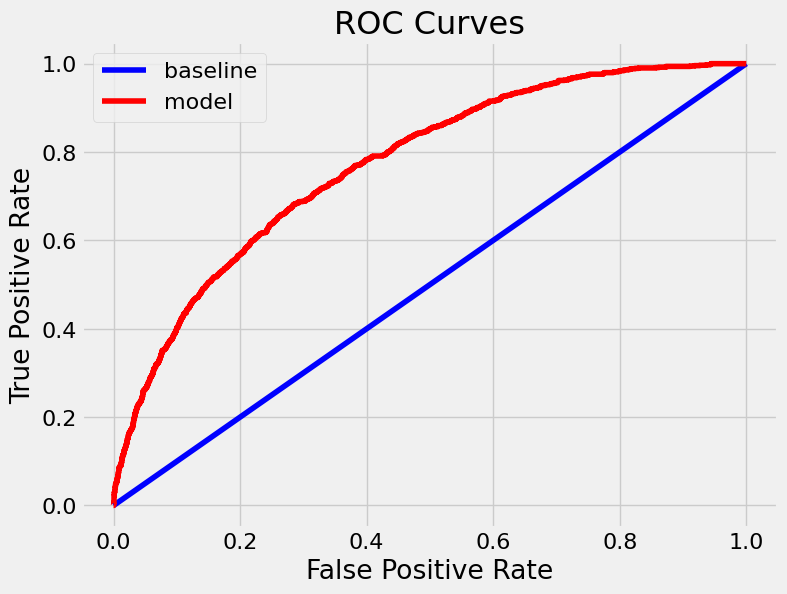

In [27]:
evaluate_model(y_test, y_train, y_test_pred_grid, y_test_probs_grid, y_train_pred_grid, y_train_probs_grid)

Confusion matrix, without normalization
[[15269  2797]
 [  555   579]]


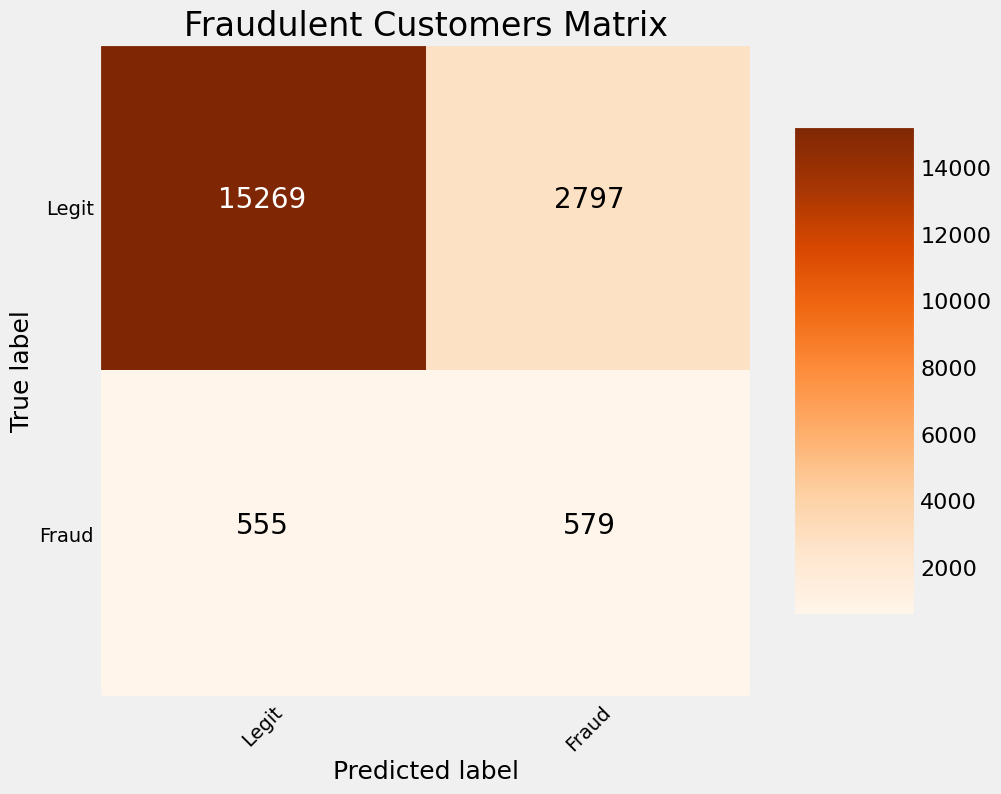

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_grid)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')


# New trial with new param grid

In [30]:
xgb3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10, scale_pos_weight=10, subsample=0.8, n_estimators=100)

grid2 = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'gamma': [0.3, 1],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [15, 18, 20],  # assuming imbalance ~15:1      
 
}

gsearch2 = GridSearchCV(
    xgb3,
    param_grid=grid2,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1
)

gsearch2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=20, subsample=0.8;, score=0.162 total time=   3.8s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=20, subsample=0.8;, score=0.163 total time=   4.1s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=20, subsample=0.8;, score=0.161 total time=   4.0s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=15, subsample=0.8;, score=0.202 total time=  14.9s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=18, subsample=0.8;, score=0.181 total time=  15.0s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=15, subsample=0.8;, score=0.195 total time=  15.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_r

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0.3, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'scale_pos_weight': [15, 18, 20], 'subsample': [0.8]},
             scoring='f1', verbose=5)

In [31]:
best_XGB_after_GridSearch2 = gsearch2.best_estimator_

In [32]:
best_XGB_after_GridSearch2.save_model('best_xgb_after_grid_search2.model')

In [33]:
print("Best parameters:", gsearch2.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 15, 'subsample': 0.8}


In [44]:
best_XGB_after_GridSearch2 = XGBClassifier()
best_XGB_after_GridSearch2.load_model('best_xgb_after_grid_search2.model')

In [45]:
#best model after Grid Search 2
y_train_pred_grid2 = best_XGB_after_GridSearch2.predict(X_train)
y_train_probs_grid2 = best_XGB_after_GridSearch2.predict_proba(X_train)[:, 1]

y_test_pred_grid2 = best_XGB_after_GridSearch2.predict(X_test)
y_test_probs_grid2 = best_XGB_after_GridSearch2.predict_proba(X_test)[:, 1]

In [46]:
f1_test_grid2 = f1_score(y_test, y_test_pred_grid2)
f1_train_grid2 =f1_score(y_train, y_train_pred_grid2)
print('Test f1 score =', f1_train_grid2)
print('Test f1 score =', f1_test_grid2)

Test f1 score = 0.2426001511715797
Test f1 score = 0.21895937277263008


Recall Baseline: 1.0 Test: 0.68 Train: 0.76
Precision Baseline: 0.06 Test: 0.13 Train: 0.14
Roc Baseline: 0.5 Test: 0.77 Train: 0.82


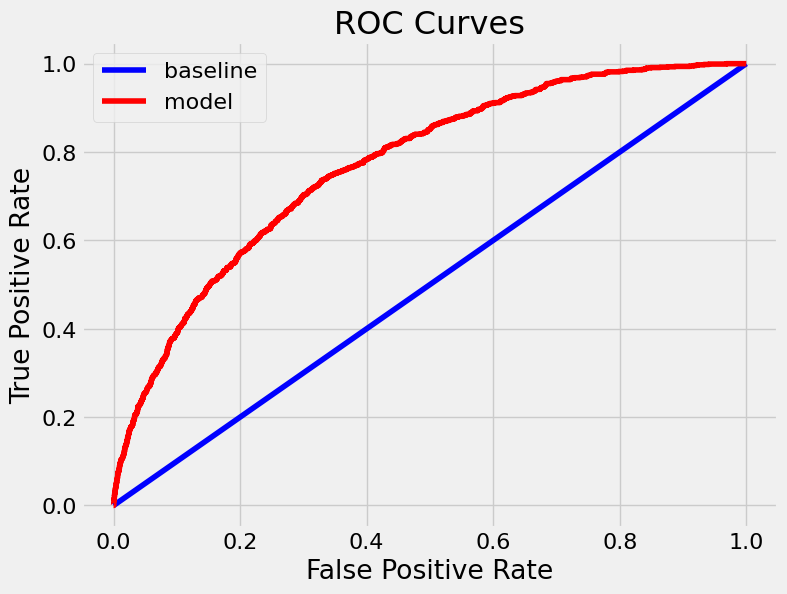

In [36]:
evaluate_model(y_test, y_train, y_test_pred_grid2, y_test_probs_grid2, y_train_pred_grid2, y_train_probs_grid2)

Confusion matrix, without normalization
[[12953  5113]
 [  366   768]]


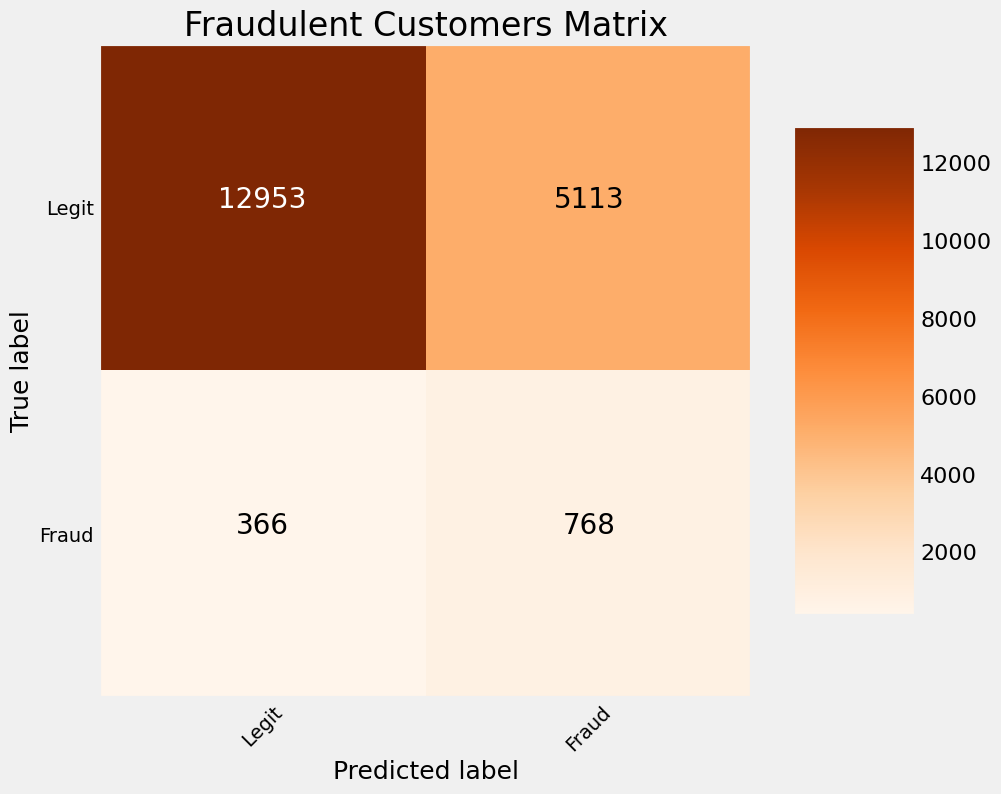

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_grid2)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')

# Random undersampler

In [15]:
%pip uninstall -y xgboost scikit-learn imbalanced-learn
%pip install xgboost==1.6.2 scikit-learn==1.2.2 imbalanced-learn==0.10.1

Found existing installation: xgboost 1.7.5
Uninstalling xgboost-1.7.5:
  Successfully uninstalled xgboost-1.7.5
Found existing installation: scikit-learn 1.3.0
Uninstalling scikit-learn-1.3.0:
  Successfully uninstalled scikit-learn-1.3.0
Found existing installation: imbalanced-learn 0.11.0
Uninstalling imbalanced-learn-0.11.0:
  Successfully uninstalled imbalanced-learn-0.11.0
Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.6 MB/s eta 0:00:00a 0:00:01
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl (8.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [imbalanced-learn][imbalanced-learn]
Note: you may need to restart the kernel to use updated packages.


In [4]:
y_agg = train_agg.pop('target')

# Train-Test-Split
# 20% examples in test data
X_train, X_temp, y_train, y_temp = train_test_split(train_agg,
                                         y_agg, 
                                         stratify = y_agg,
                                         test_size = 0.3, 
                                         random_state = 42)
# Train-eval split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# Features for feature importance
features = list(X_train.columns)

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [6]:
rus = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print("Class distribution after undersampling:", dict(zip(*np.unique(y_train_resampled, return_counts=True))))

Class distribution after undersampling: {0: 17643, 1: 5293}


In [7]:
xgb4 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    n_estimators=100
)

# Create new base model for GridSearch
base_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    n_estimators=100
)

grid3 = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'gamma': [0.3, 1],
    'colsample_bytree': [0.8, 1.0]
}

gsearch3 = GridSearchCV(
    estimator=base_model,  # Use fresh model instead of fitted one
    param_grid=grid3,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1
)

# Simple fit without extra parameters
gsearch3.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3;, score=0.198 total time=   3.6s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3;, score=0.272 total time=   3.7s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3;, score=0.192 total time=   3.8s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3;, score=0.188 total time=   3.8s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3;, score=0.264 total time=   3.9s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.280 total time=   6.0s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.270 total time=   6.1s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.258 total time=   6.1s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learnin

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0.3, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
             scoring='f1', verbose=5)

In [20]:
best_XGB_after_GridSearch3 = gsearch3.best_estimator_

Best parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5}


In [ ]:
best_XGB_after_GridSearch3.save_model('best_xgb_after_grid_search3.model')

In [11]:
print("Best parameters:", gsearch3.best_params_)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5}


In [47]:
best_XGB_after_GridSearch3 = XGBClassifier()
best_XGB_after_GridSearch3.load_model('best_xgb_after_grid_search3.model')

In [48]:
#best model after Grid Search
y_train_pred_grid3 = best_XGB_after_GridSearch3.predict(X_train)
y_train_probs_grid3 = best_XGB_after_GridSearch3.predict_proba(X_train)[:, 1]

y_test_pred_grid3 = best_XGB_after_GridSearch3.predict(X_test)
y_test_probs_grid3 = best_XGB_after_GridSearch3.predict_proba(X_test)[:, 1]

In [49]:
f1_test_grid3 = f1_score(y_test, y_test_pred_grid3)
f1_train_grid3 =f1_score(y_train, y_train_pred_grid3)
print('Test f1 score =', f1_train_grid3)
print('Test f1 score =', f1_test_grid3)


Test f1 score = 0.2896789223133799
Test f1 score = 0.23535062439961577


Recall Baseline: 1.0 Test: 0.22 Train: 0.27
Precision Baseline: 0.06 Test: 0.26 Train: 0.31
Roc Baseline: 0.5 Test: 0.77 Train: 0.81


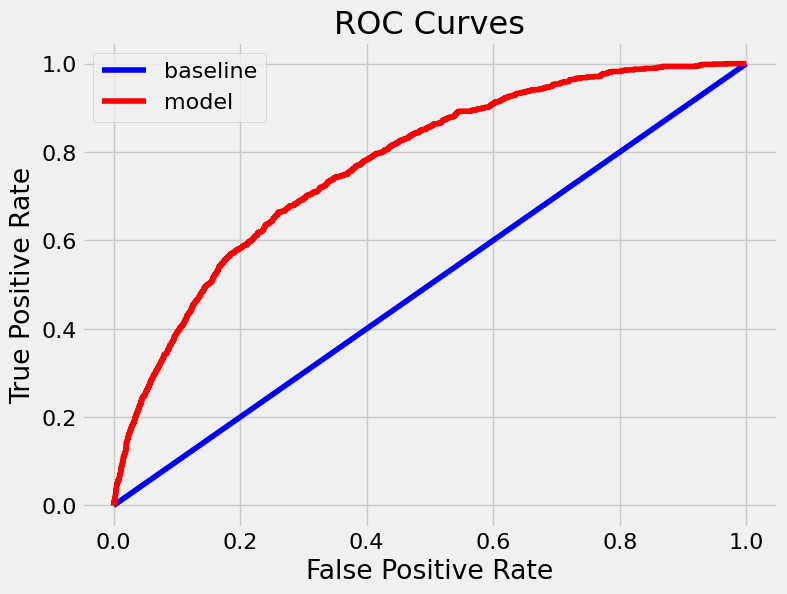

In [17]:
evaluate_model(y_test, y_train, y_test_pred_grid3, y_test_probs_grid3, y_train_pred_grid3, y_train_probs_grid3)

Confusion matrix, without normalization
[[17363   703]
 [  889   245]]


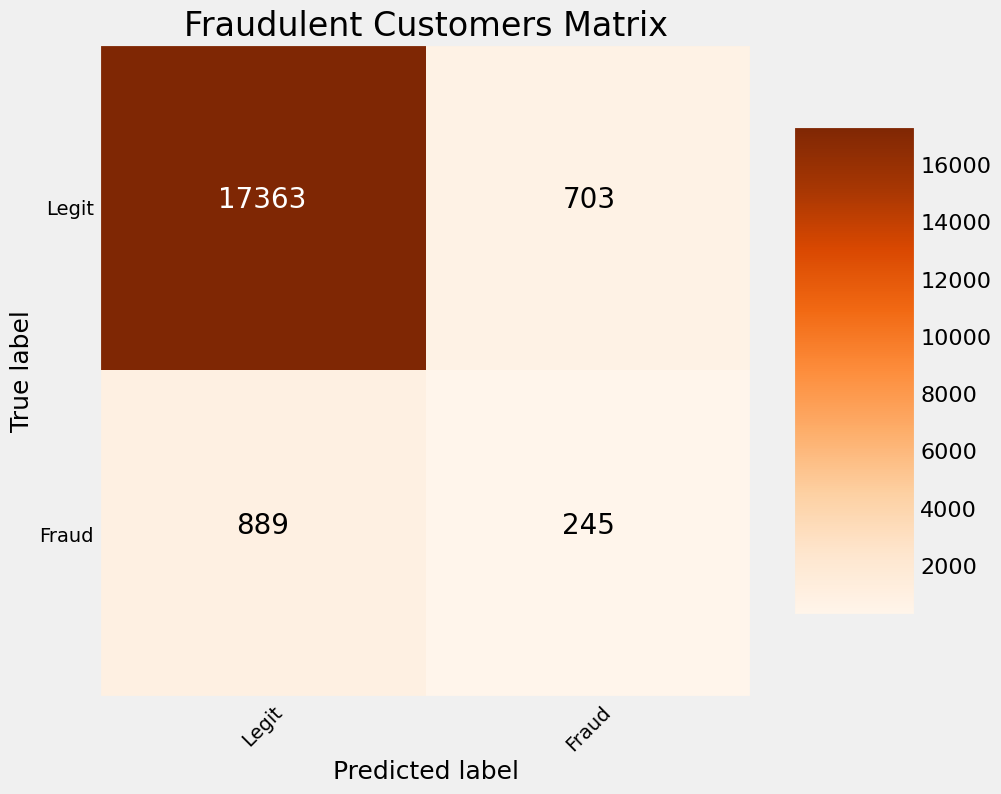

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_grid3)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')

In [21]:
xgb5 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    n_estimators=100
)

grid4 = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'gamma': [0.3, 1],
    'colsample_bytree': [0.8, 1.0]
}

gsearch4 = GridSearchCV(
    estimator=xgb5,  # Use fresh model instead of fitted one
    param_grid=grid4,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1
)

# Simple fit without extra parameters
gsearch4.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)], verbose=False)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3;, score=0.192 total time=   5.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3;, score=0.198 total time=   5.7s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3;, score=0.188 total time=   5.7s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3;, score=0.264 total time=   5.8s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3;, score=0.272 total time=   5.9s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.258 total time=   8.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.280 total time=   8.4s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=5;, score=0.270 total time=   8.6s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learnin

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0.3, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
             scoring='f1', verbose=5)

In [22]:
print("Best parameters:", gsearch4.best_params_)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5}


In [23]:
best_XGB_after_GridSearch4 = gsearch4.best_estimator_

In [24]:
best_XGB_after_GridSearch4.save_model('best_xgb_after_grid_search4.model')

In [50]:
best_XGB_after_GridSearch4 = XGBClassifier()
best_XGB_after_GridSearch4.load_model('best_xgb_after_grid_search4.model')

In [51]:
#best model after Grid Search
y_train_pred_grid4 = best_XGB_after_GridSearch4.predict(X_train)
y_train_probs_grid4 = best_XGB_after_GridSearch4.predict_proba(X_train)[:, 1]

y_test_pred_grid4 = best_XGB_after_GridSearch4.predict(X_test)
y_test_probs_grid4 = best_XGB_after_GridSearch4.predict_proba(X_test)[:, 1]

In [52]:
f1_test_grid4 = f1_score(y_test, y_test_pred_grid4)
f1_train_grid4 =f1_score(y_train, y_train_pred_grid4)
print('Test f1 score =', f1_train_grid4)
print('Test f1 score =', f1_test_grid4)


Test f1 score = 0.2896789223133799
Test f1 score = 0.23535062439961577


Recall Baseline: 1.0 Test: 0.22 Train: 0.27
Precision Baseline: 0.06 Test: 0.26 Train: 0.31
Roc Baseline: 0.5 Test: 0.77 Train: 0.81


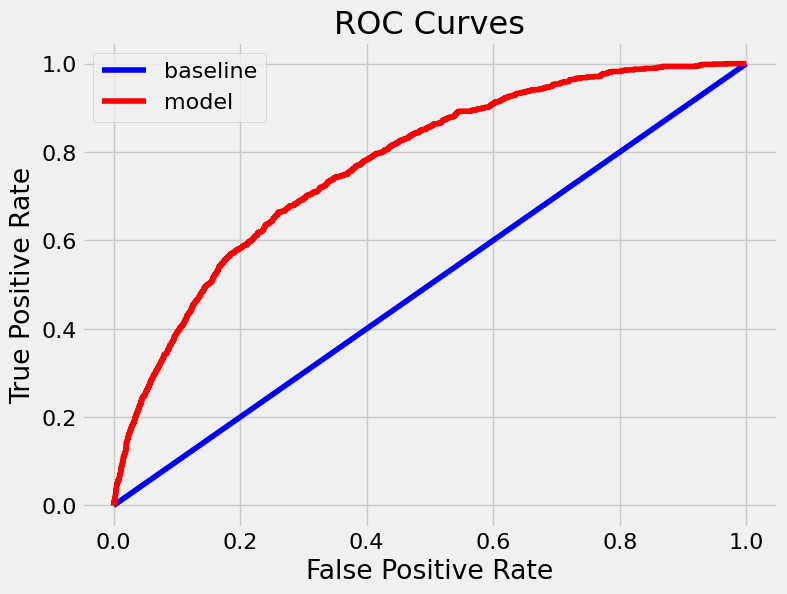

In [26]:
evaluate_model(y_test, y_train, y_test_pred_grid4, y_test_probs_grid4, y_train_pred_grid4, y_train_probs_grid4)

Confusion matrix, without normalization
[[17363   703]
 [  889   245]]


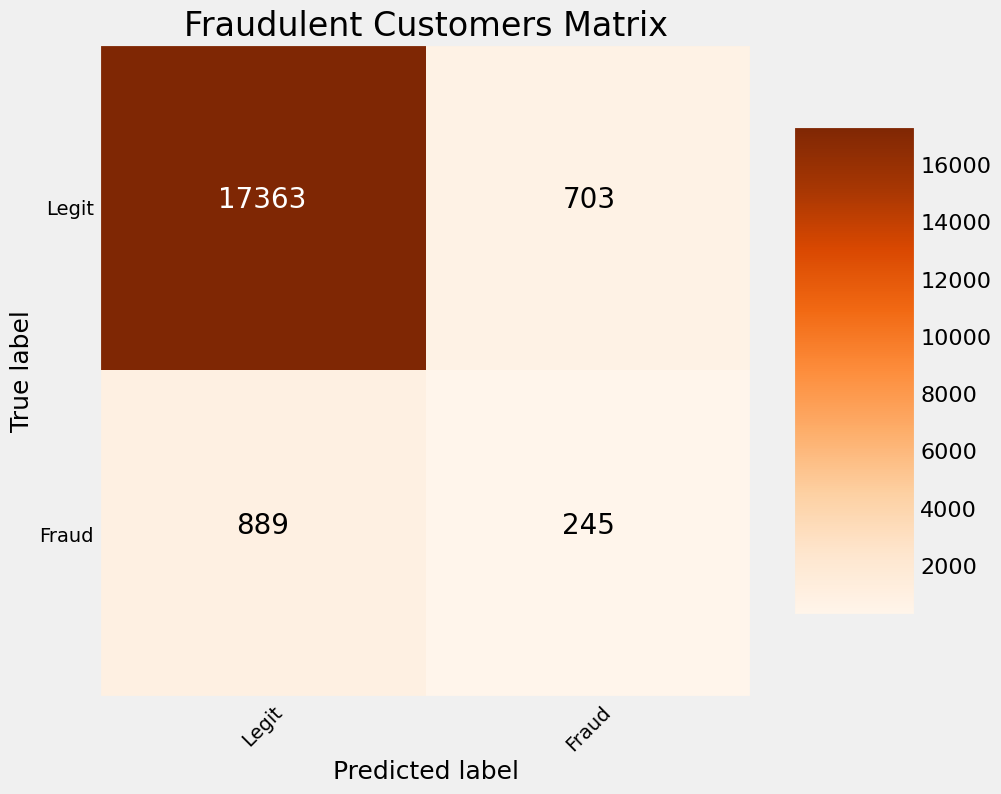

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_grid3)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')

# SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarized. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [30]:
# Alias
train = df_train_non_agg
test_final = df_final_test_non_agg
train_agg = df_train_agg
test_final_agg = df_final_test_agg

In [31]:
y_agg = train_agg.pop('target')

# Train-Test-Split
# 20% examples in test data
X_train, X_temp, y_train, y_temp = train_test_split(train_agg,
                                         y_agg, 
                                         stratify = y_agg,
                                         test_size = 0.3, 
                                         random_state = 42)
# Train-eval split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# Features for feature importance
features = list(X_train.columns)

In [32]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', early_stopping_rounds=10, subsample=0.8, n_estimators=100)

grid_smote = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'gamma': [0.3, 1],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [15, 18, 20],  # useful for class imbalance!
}

gsearch_smote = GridSearchCV(
    xgb_smote,
    param_grid=grid_smote,
    scoring='f1',
    cv=3,
    verbose=5,
    n_jobs=-1
)

gsearch_smote.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val, y_val)],
    verbose=False
)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=15, subsample=0.8;, score=0.667 total time=   7.6s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=18, subsample=0.8;, score=0.676 total time=   7.6s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=15, subsample=0.8;, score=0.678 total time=   7.6s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=18, subsample=0.8;, score=0.678 total time=   7.5s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=18, subsample=0.8;, score=0.677 total time=   7.7s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.05, max_depth=3, scale_pos_weight=15, subsample=0.8;, score=0.676 total time=   7.8s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_r

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0.3, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'scale_pos_weight': [15, 18, 20], 'subsample': [0.8]},
             scoring='f1', verbose=5)

In [55]:
best_XGB_after_GridSearch_smote = gsearch_smote.best_estimator_

In [56]:
best_XGB_after_GridSearch_smote.save_model('best_xgb_after_grid_search_smote.model')

In [57]:
print("Best parameters:", gsearch_smote.best_params_)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'scale_pos_weight': 15, 'subsample': 0.8}


In [58]:
best_XGB_after_GridSearch_smote = XGBClassifier()
best_XGB_after_GridSearch_smote.load_model('best_xgb_after_grid_search_smote.model')

In [59]:
#best model after Grid Search 2
y_train_pred_grid_smote = best_XGB_after_GridSearch_smote.predict(X_train)
y_train_probs_grid_smote = best_XGB_after_GridSearch_smote.predict_proba(X_train)[:, 1]

y_test_pred_grid_smote = best_XGB_after_GridSearch_smote.predict(X_test)
y_test_probs_grid_smote = best_XGB_after_GridSearch_smote.predict_proba(X_test)[:, 1]

In [60]:
f1_test_grid_smote = f1_score(y_test, y_test_pred_grid_smote)
f1_train_grid_smote =f1_score(y_train, y_train_pred_grid_smote)
print('Test f1 score =', f1_train_grid_smote)
print('Test f1 score =', f1_test_grid_smote)


Test f1 score = 0.12291701432760388
Test f1 score = 0.12192131951409783


Recall Baseline: 1.0 Test: 0.96 Train: 0.97
Precision Baseline: 0.06 Test: 0.07 Train: 0.07
Roc Baseline: 0.5 Test: 0.68 Train: 0.69


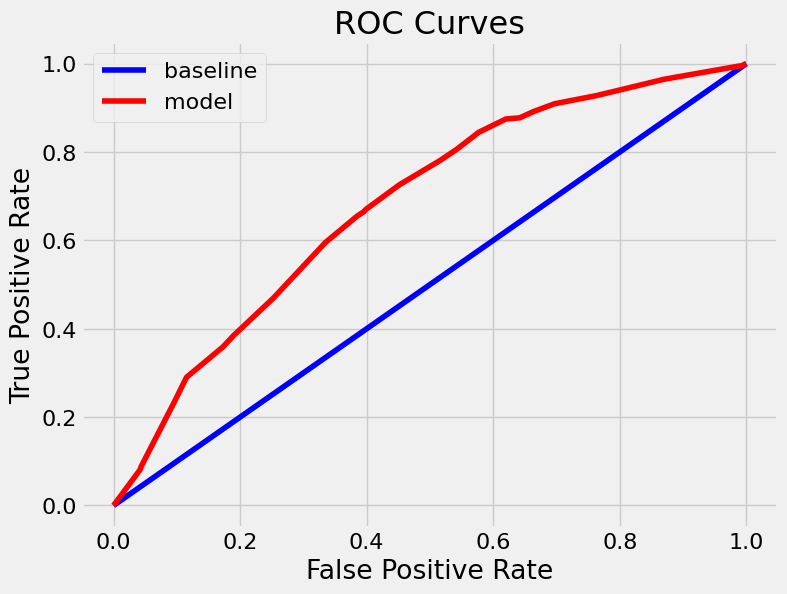

In [36]:
evaluate_model(y_test, y_train, y_test_pred_grid_smote, y_test_probs_grid_smote, y_train_pred_grid_smote, y_train_probs_grid_smote)

Confusion matrix, without normalization
[[ 2348 15718]
 [   40  1094]]


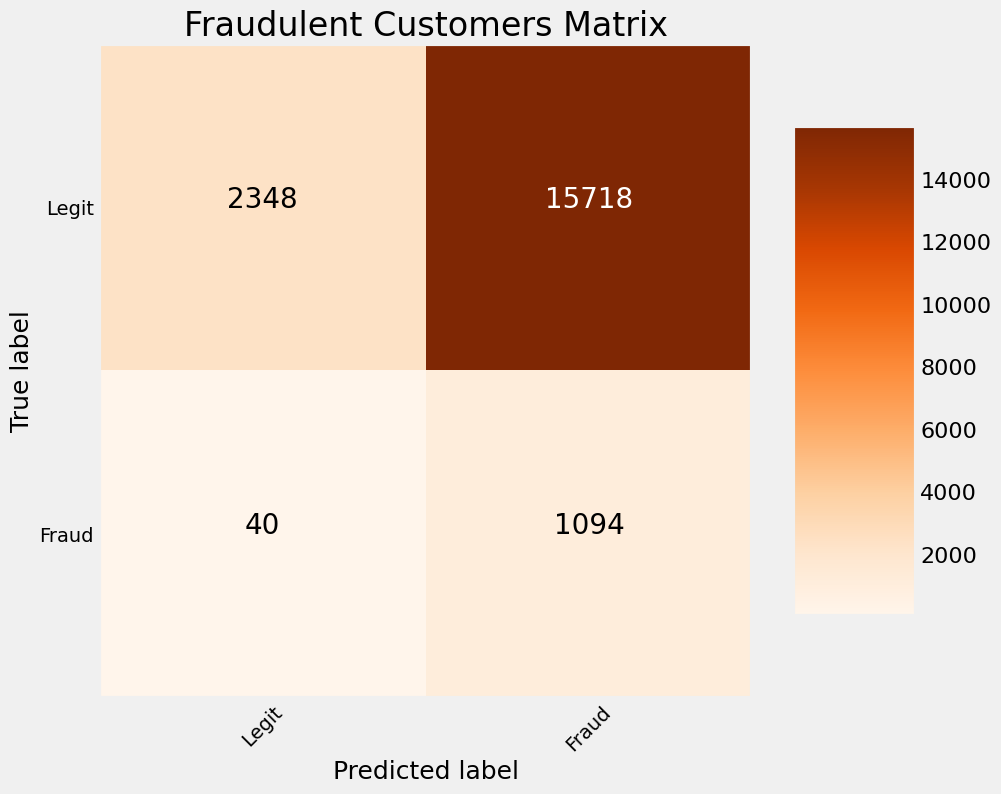

In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_grid_smote)
plot_confusion_matrix(cm, classes = ['Legit', 'Fraud'],
                      title = 'Fraudulent Customers Matrix')

# PCA

In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [65]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [66]:
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Label'] = y_train.values

In [67]:
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color=df_pca['Label'].map({0: 'Legit', 1: 'Fraud'}),
    title='3D PCA Visualization of Training Data',
    opacity=0.6
)
fig.show()
